<a href="https://colab.research.google.com/github/lucadonnoh/progetto-deblur/blob/main/Progetto_Deblur_CN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto Deblur**

---

Un'azienda vuole commercializzare un dispositivo di acquisizione immagini, del quale si sa che acquisisce con rumore Gaussiano additivo e sfocatura Gaussiana.
Il modello è quindi:

\begin{align*}
    b = A x_{true} + \eta
\end{align*}

Dove $A \in \mathbb{R}^{mn}$ è la matrice di sfocamento, $\eta \sim \mathcal{N}(0, \sigma^2)$ rumore additivo con varianza $\sigma^2$ incognita, $b \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine corrotta (acquisita) $B \in \mathbb{R}^{m \times n}$, $x_{true} \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine originale $X_{true} \in \mathbb{R}^{m \times n}$.


1. Dopo aver importato le librerie necessarie, assegnare ad una variabile $X$ l'immagine $\texttt{cameraman}$, ottenibile tramite la libreria $\texttt{skimage.data}$ con il nome di $\texttt{camera()}$, effettuarne il $\texttt{reshape}$ e assegnarlo alla variabile $x$.

2. Tramite la funzione $\texttt{skimage.filters.gaussian}$ aggiungere sfocatura Gaussiana ad $X$ per ottenere $X_{blur}$, che rappresenta il reshape ad immagine di $x_{blur} = A x_{true}$, con $A$ matrice di sfocatura.

3. Caricare su una variabile $\eta$, della stessa dimensione di $X_{true}$, una realizzazione di rumore gaussiano con varianza $\sigma = 0.1$ (fare riferimento alle slides per la formula). 
Utilizzare $\eta$ per corrompere l'immagine $X_{blur}$ e calcolare $B = X_{blur} + \eta$. \\
Visualizzare i risultati ottenuti.

In [42]:
def gkern(kernlen, nsig):
  """
  Genera un kernel per la realizzazione di un filtro di sfocatura Gaussiana.

  Input ->
  kernlen: diametro della sfocatura gaussiana.
  nsig:    varianza della sfocatura. Più basso, più sfoca.

  Output -> Kernel Gaussiano di dimensione (kernlen+1) x (kernlen+1) e varianza nsig.
  """
  import scipy.stats as st

  x = np.linspace(-nsig, nsig, kernlen+1)
  kern1d = np.diff(st.norm.cdf(x))
  kern2d = np.outer(kern1d, kern1d)
  return kern2d/kern2d.sum()

def A(x, d=7, sigma=0.5):
  """
  Esegue il prodotto Ax, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n)) 
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(K_ext * x))

def AT(x, d=7, sigma=0.5):
  """
  Esegue il prodotto A^T x, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(np.conj(K_ext) * x))

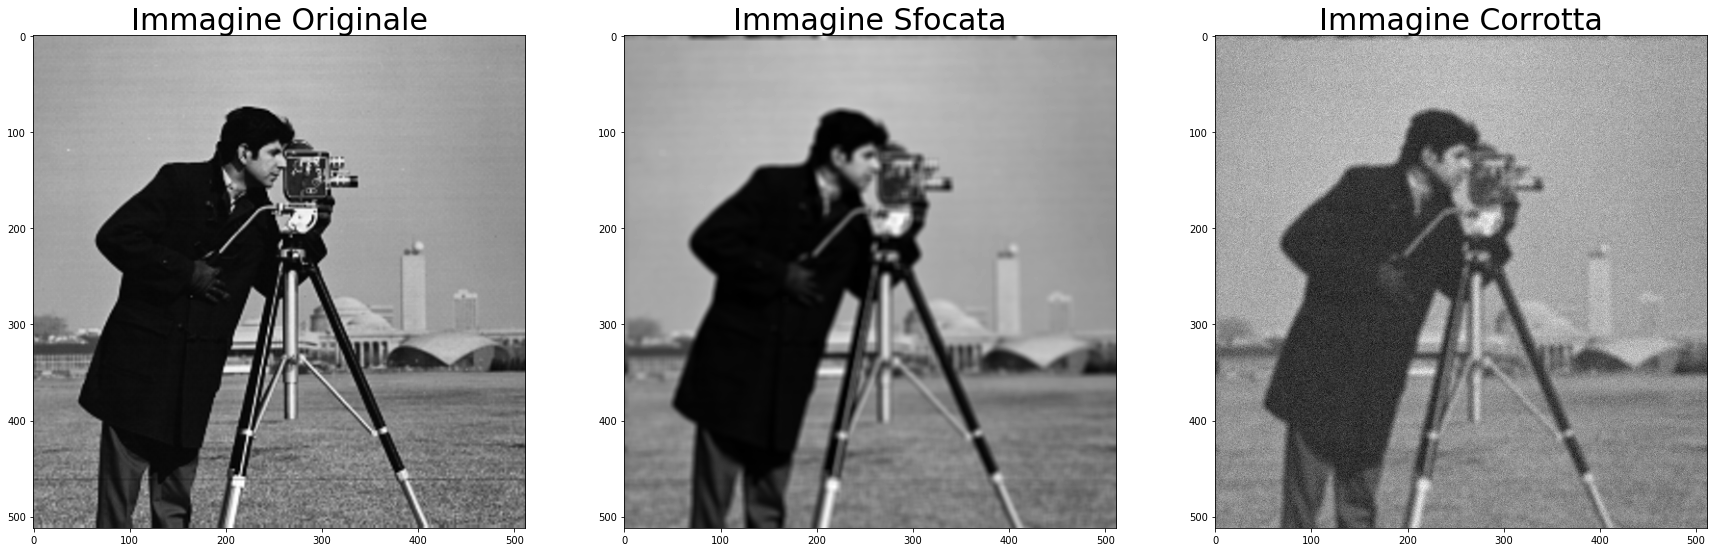

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters

# 1
X = data.camera()
m, n = X.shape
x = X.reshape(m*n) # array m*n


# 2
X_blur = A(X) # matrice
x_blur = X_blur.reshape(m*n) # array


# 3
# Generiamo il rumore eta
sigma = 0.1 # Varianza del rumore
eta = np.random.normal(size=X_blur.shape) # random gaussian distribution
eta /= np.linalg.norm(eta, 'fro') # norma di frobenius
eta *= sigma * np.linalg.norm(X_blur,'fro')

# Aggiungiamo il rumore all'immagine sfocata
B = X_blur + eta
b = B.reshape(m*n)

# Visualizziamo i risultati
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(X_blur, cmap='gray')
plt.title('Immagine Sfocata', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

plt.show()

Il problema di ricostruire l'immagine originale partendo dalla sua corruzione $b$, si può riscrivere come un problema di ottimizzazione

\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 \hspace{2cm} (1)
\end{align}

4. Risolvere il problema (1) utilizzando l'algoritmo di discesa del gradiente con scelta del passo tramite backtracking, ricordando che, se 
\begin{align*}
  f(x) = \frac{1}{2} ||Ax - b||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b)
\end{align*}
E chiamare la soluzione ottenuta $x_{naive}$.

5. Modificare l'algoritmo precedente a far restituire l'errore tra l'immagine ricostruita al passo $k$ e l'immagine originale, per ogni $k$. Visualizzare il grafico dell'errore, e individuare per quale valore di $k$ si ha semiconvergenza. Per tale valore, calcolare l'immagine ricostruita e chiamarla $x_{trunc}$.

In [44]:
# 4 - 5 
#Modificare l'algoritmo è stato interpretato come "sovrascrivere il precedente"

def f(x, b): #
  return 0.5*(np.linalg.norm(A(x)-b))**2

def grad_f(x, b):
  return AT(A(x)-b)

def next_step(x, b, f, grad):
  alpha = 0.5
  rho = 0.5
  c1 = 0.25
  k = 0

  while f(x-alpha*grad, b) > f(x, b) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize(x0, x_true, b, maxit, abstop):
  x = x0
  grad = grad_f(x, b)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step(x, b, f, grad) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f(x, b)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
    if k==5:
      print(x==)                                #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    print(".", end='')

  err = err[0:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)


SyntaxError: ignored

..................................................
 [12042.71541901 10923.6075204  10310.08803455  9945.8061797
  9715.44425714  9564.15294118  9463.65506893  9398.09721488
  9357.89660507  9336.88541375  9330.88584965  9336.94793371
  9352.91582339  9377.16776752  9408.45315832  9445.78658385
  9488.37675288  9535.57751806  9586.85333078  9641.75436984
  9699.89830417  9760.9566972   9824.64471792  9890.71324579
  9958.9427344  10029.13838492 10101.12630699 10174.75043291
 10249.87001273 10326.35756173 10404.09716377 10482.98305711
 10562.91844631 10643.81449651 10725.58947625 10808.16802186
 10891.48050228 10975.46246725 11060.05416539 11145.2001209
 11230.84876013 11316.95208047 11403.46535551 11490.34687153
 11577.55769095 11665.06143941 11752.8241133  11840.81390541
 11929.00104644 12017.35766061]


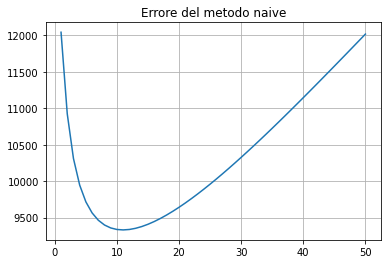

...........

In [45]:
def plot( iters, error, title): 
  err_iteration = np.linspace(1, iters, error.size)
  plt.plot(err_iteration, error)
  plt.title(title)
  plt.grid()
  plt.show()

def find_x_trunc(error):
  return np.where(error == np.amin(error))[0]

MAXITERATIONS=50
ABSOLUTE_STOP=1.e-5

x0 = np.zeros(X.shape) # immagine ricostruita al passo 0
x_naive, ite_naive, err_naive = minimize(B, X, B, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_naive)
plot(ite_naive, err_naive,"Errore del metodo naive")

X_trunc_index = find_x_trunc(err_naive)
X_trunc,_,erroredio= minimize(B,X,B,X_trunc_index+1, ABSOLUTE_STOP)

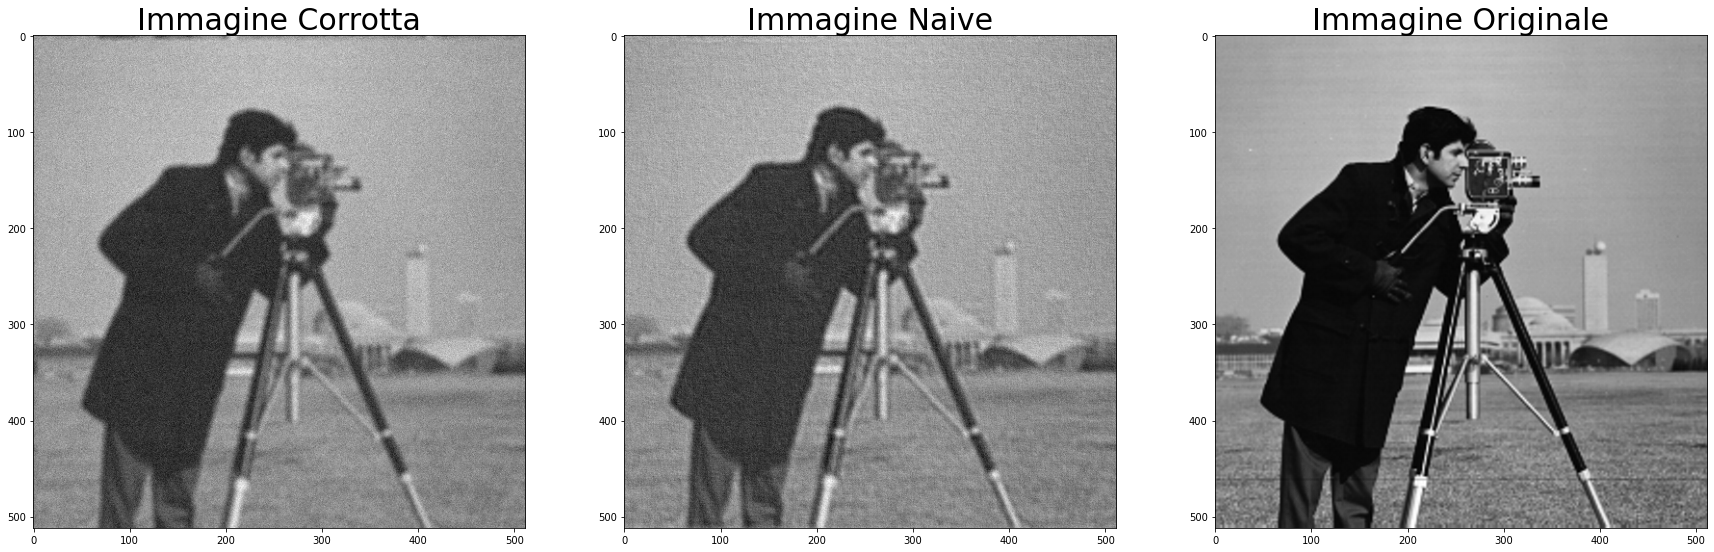

In [46]:
#Plottiamo il risultato
plt.figure(figsize=(30, 10))

fig1 = plt.subplot(1, 3, 1)
fig1.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

fig2 = plt.subplot(1, 3, 2)
fig2.imshow(X_trunc, cmap='gray')
plt.title('Immagine Naive', fontsize=30)

fig3 = plt.subplot(1, 3, 3)
fig3.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

plt.show()

Per risolvere la semiconvergenza, si introduce il problema regolarizzato

\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 \hspace{2cm} (2)
\end{align*}

con $\lambda > 0$ parametro di regolarizzazione.

6. Sfruttando il fatto che, se
\begin{align*}
f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b) + \lambda x
\end{align*}
Risolvere il problema (2) utilizzando l'algoritmo precedente per diversi valori di $\lambda$, e stimare il valore ottimale di $\lambda$ che minimizzi l'errore tra l'immagine ricostruita e l'immagine originale (metodo euristico per il parametro di regolarizzazione). Chiamare $x_{\lambda}$ tale soluzione. \\

7. Stimare il valore ottimale di $\lambda$ tramite principio di discrepanza, ovvero scegliere il più grande $\lambda$ tale che
\begin{align*}
  ||A x_\lambda - b||_2^2 \leq ||\eta||_2^2
\end{align*}
Dove $\eta$ è il rumore. Chiamare $x_\lambda^{disc}$ la soluzione ottenuta dal $\lambda$ calcolato con principio di discrepanza.
 

In [47]:
def f_reg(x, b, lamb):
  return 0.5*(np.linalg.norm(A(x)-b))**2 + 0.5*lamb*np.linalg.norm(x)**2

def grad_f_reg(x, b, lamb):
  return AT(A(x)-b) + lamb*x

def next_step_reg(x, b, f, grad, lamb):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg(x-alpha*grad, b, lamb) > f_reg(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg(x0, x_true, b, lamb, maxit, abstop):
  x = x0
  grad = grad_f_reg(x, b, lamb)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg(x, b, f, grad, lamb) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg(x, b, lamb)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    #print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)



 [10414.94989327  9592.13671445  9220.76031433  9008.01568754
  8880.2216908   8803.95021134  8762.45688317  8745.95875443
  8748.21023941  8764.9235979   8792.99219093  8830.07089728
  8874.33388183  8924.32617637  8978.86797645  9036.99009156
  9097.88864997  9160.89219343  9225.4370434   9291.04837917
  9357.32538457  9423.92937531  9490.57416557  9557.0181546
  9623.05776011  9688.52192405  9753.26748382  9817.17525082
  9880.14667234  9942.10097888 10002.97273808 10062.70975145
 10121.27124117 10178.62628399 10234.75245572 10289.63465636
 10343.26409031 10395.63738002 10446.75579494 10496.62458015
 10545.25237126 10592.65068431 10638.83347077 10683.8167292
 10727.61816638 10770.2569015  10811.75320803 10852.12828855
 10891.40407836 10929.6030744 ]


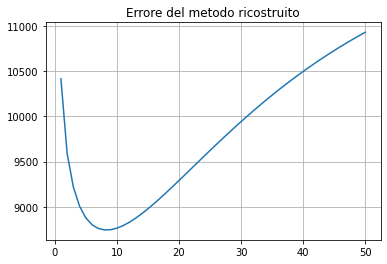

[8745.95875443]


In [48]:
def lambottimale(x, b, max):
  lamb=0.00000001
  k=0
  x,_,_ = minimize_reg(B,X,B,lamb, max, ABSOLUTE_STOP)
  rat = 1.1
  while np.linalg.norm(A(x)-b)**2 <= np.linalg.norm(eta)**2:
    lamb *= rat
    x,_,_ = minimize_reg(B,X,B,lamb, max, ABSOLUTE_STOP)
    k+=1
    print(",", end='')
  print("it: ", k)
  return lamb/rat

lamb = 0.02155582137126536 #lambda in modo euristico

x0 = np.zeros(X.shape) # immagine ricostruita al passo 0
(x_rec, ite_rec, err_reg) = minimize_reg(B, X, B, lamb, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_reg)
plot(ite_rec, err_reg,"Errore del metodo ricostruito")

X_reg_index = find_x_trunc(err_reg)
print(err_reg[X_reg_index])
X_lambda,_,_= minimize_reg(B, X, B, lamb, X_reg_index+1, ABSOLUTE_STOP)



 [10442.18939755  9593.710164    9208.48058288  8979.23307962
  8835.1546885   8742.725958    8685.33474341  8653.21700831
  8640.12457995  8641.75347332  8654.97603736  8677.42520733
  8707.25432186  8742.98968803  8783.43528867  8827.60831751
  8874.69378715  8924.01142954  8974.99082142  9027.15220648
  9080.0913892   9133.46762339  9186.99375959  9240.42813472
  9293.56783133  9346.24303103  9398.31225418  9449.65832557
  9500.18494045  9549.81373097  9598.48175245  9646.13932388
  9692.74816858  9738.27981035  9782.71418773  9826.03845507
  9868.24594404  9909.33526305  9949.30951588  9988.175623
 10025.94373202 10062.6267052  10098.23967399 10132.7996517
 10166.32519686 10198.83612065 10230.35323281 10260.89812107
 10290.49295989 10319.1603449 ]


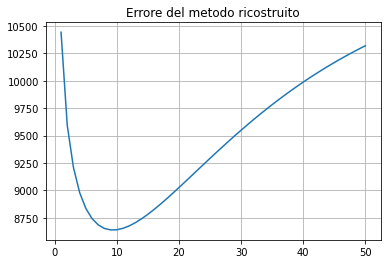

[8640.12457995]


In [54]:
lamb_disc = 0.025625815225418787 #lamda tramite condizione discrepanza

x0 = np.zeros(X.shape) # immagine ricostruita al passo 0
(X_reg, ite_reg, err_reg) = minimize_reg(B, X, B, lamb_disc, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_reg)
plot(ite_rec, err_reg,"Errore del metodo ricostruito")

X_reg_index = find_x_trunc(err_reg)
print(err_reg[X_reg_index])
X_lambda_disc,_,_= minimize_reg(B, X, B, lamb_disc, X_reg_index+1, ABSOLUTE_STOP)

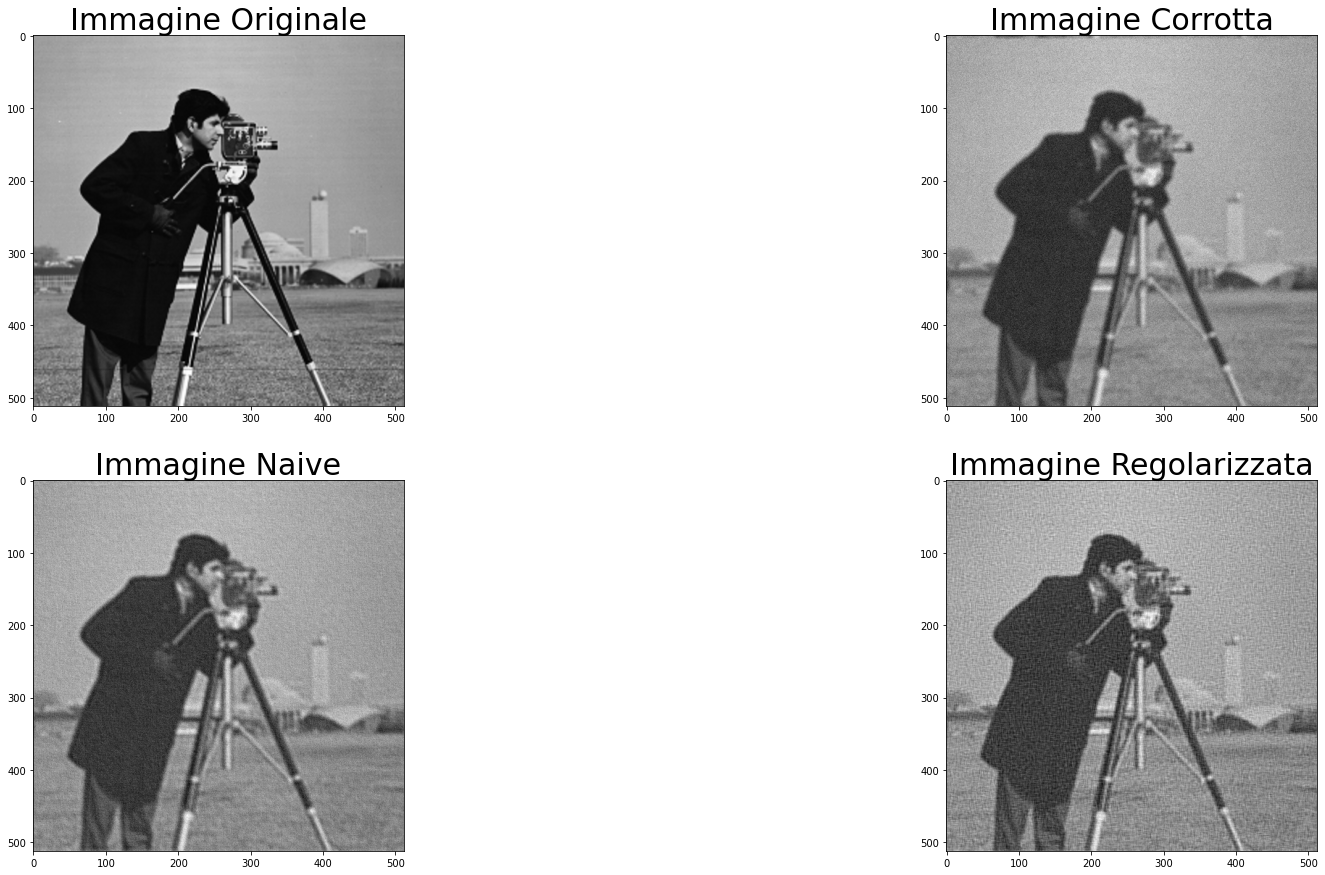

In [65]:
#Plottiamo il risultato
plt.figure(figsize=(30, 15))

fig0 = plt.subplot(2, 2, 2)
fig0.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

fig1 = plt.subplot(2, 2, 3)
fig1.imshow(X_trunc, cmap='gray')
plt.title('Immagine Naive', fontsize=30)

fig2 = plt.subplot(2, 2, 4)
fig2.imshow(X_reg, cmap='gray')
plt.title('Immagine Regolarizzata', fontsize=30)

fig3 = plt.subplot(2, 2, 1)
fig3.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

plt.show()

8. Ripetere quanto fatto nel punto 6, utilizzando la norma 1 come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda ||x||_1 \hspace{2cm} (3)
\end{align*}
Dove la funzione obiettivo ha gradiente
\begin{align*}
  A^T(Ax - b) + \lambda \hspace{2px} sign(x)
\end{align*}

In [ ]:
def f_reg_1(x, b, lamb): #
  return 0.5*(np.linalg.norm(A(x)-b))**2 + lamb*np.linalg.norm(x, 1)**2

def grad_f_reg_1(x, b, lamb):
  return AT(A(x)-b) + lamb*np.sign(x)

def next_step_reg_1(x, b, f, grad, lamb):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg_1(x-alpha*grad, b, lamb) > f_reg_1(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg_1(x0, x_true, b, lamb, maxit, abstop):
  x = x0
  grad = grad_f_reg_1(x, b, lamb)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg_1(x, b, f, grad, lamb) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg_1(x, b, lamb)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)

In [ ]:
#trovare il lamba ottimale

9. ($\textit{facoltativo}$) Ripetere quanto fatto nei punti 6 e 8, utilizzando una norma mista come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 + \mu ||x||_1 \hspace{2cm} (4)
\end{align*}

In [ ]:
#TODO: va definito mu
#TODO: va anche trovato il gradiente, davide dice che dobbiam esser bravi a trovarcelo

def f_reg_mista(x, b, lamb): 
  return 0.5*(np.linalg.norm(A(x)-b))**2 + 0.5*lamb*np.linalg.norm(x)**2 + mu*np.linalg.norm(x1,1)

def grad_f_reg_mista(x, b, lamb):
  return AT(A(x)-b) + lamb*np.sign(x)

def next_step_reg_mista(x, b, f, grad, lamb):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg_mista(x-alpha*grad, b, lamb) > f_reg_mista(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg_mista(x0, x_true, b, lamb, maxit, abstop):
  x = x0
  grad = grad_f_reg_mista(x, b, lamb)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg_mista(x, b, f, grad, lamb) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg_mista(x, b, lamb)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)

In [ ]:
#trovare il lamba ottimale

---

# Analisi dei risultati

---

Per ognuna delle soluzioni trovate, calcolare:

*   Errore relativo rispetto alla soluzione esatta $x_{true}$.
*   PSNR (Peak Signal to Noise Ratio).

Visualizzare le ricostruzioni ottenute con i vari metodi, e confrontare, sia numericamente che attraverso dei grafici, PSNR ed errore relativo ottenuti dalle ricostruzioni. Includere nel confronto, il valore delle metriche per l'immagine corrotta $b$.


Ripetere tutti i passaggi, variando il livello del rumore (controllato dalla variabile $\sigma$), i parametri del kernel di sfocamento Gaussiano, e l'immagine di test. \\
Per la scelta delle immagini di test, utilizzare immagini **in bianco e nero, a scelta**, prese da internet, che rispettino i seguenti criteri:


*   Almeno un'immagine "geometrica", ovvero con pochi dettagli e contorni netti e ben contrastati (es. QRCode, Codice a Barre, Scacchiera...).
*   Almeno un'immagine "fotografica", ovvero con molti dettagli e livelli di grigio sfocati.
*   Almeno un'immagine contenente del testo, che diventerà difficilmente leggibile dopo il processo di sfocamento.


Osservare quale metodo di ricostruzione si comporta meglio nei vari esperimenti, ricordandosi corrompere l'immagine di input sia con rumore Gaussiano che con sfocatura.

